<a href="https://colab.research.google.com/github/vineetajaiswal/Campus-connect/blob/main/Arcade_Stenosis_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ARCADE Stenosis Segmentation — Ready-to-run Colab script
# Instructions:
# 1) Open a new Google Colab notebook.
# 2) Create a new code cell, paste the contents of this file into it (or upload this .py file and use "Open in Colab").
# 3) Make sure Runtime -> Change runtime type -> GPU is selected.
# 4) Run the cells in order. The script is split with `# %%` markers to indicate logical notebook cells.

# %%
# Cell 1 — Install dependencies and check GPU
!pip install -q pycocotools tensorflow==2.12.0 matplotlib opencv-python tqdm

import os
import sys
import json
import zipfile
import random
import shutil
import datetime
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, losses, metrics

from pycocotools import mask as mask_utils

print('TensorFlow:', tf.__version__)
print('GPU available:', tf.config.list_physical_devices('GPU'))

# %%
# Cell 2 — Mount Google Drive (user confirmed path)
from google.colab import drive

drive.mount('/content/drive')

# Path to arcade.zip in your Drive (change if different)
drive_zip_path = '/content/drive/MyDrive/arcade.zip'
work_dir = '/content/arcade_project'
os.makedirs(work_dir, exist_ok=True)

# If the zip exists in Drive, copy to local and unzip
if os.path.exists(drive_zip_path):
    print('Found arcade.zip at', drive_zip_path)
    local_zip = os.path.join(work_dir, 'arcade.zip')
    if not os.path.exists(local_zip):
        shutil.copy(drive_zip_path, local_zip)
    print('Unzipping...')
    with zipfile.ZipFile(local_zip, 'r') as z:
        z.extractall(work_dir)
    print('Extracted to', work_dir)
else:
    raise FileNotFoundError(f"Cannot find arcade.zip at {drive_zip_path}. Please upload or change the path.")

# %%
# Cell 3 — Locate stenosis task folder and inspect structure
# ARCADE extraction usually creates a top-level folder; try to find `stenosis` task
possible = []
for root, dirs, files in os.walk(work_dir):
    for d in dirs:
        if d.lower() == 'stenosis':
            possible.append(os.path.join(root, d))

if not possible:
    raise FileNotFoundError('Could not find a `stenosis` folder inside the unzipped archive. Check the zip contents.')

# take the first found stenosis folder
stenosis_dir = possible[0]
print('Using stenosis folder:', stenosis_dir)
print('Contents:', os.listdir(stenosis_dir))

# Expecting train/val/test inside stenosis_dir
for split in ['train','val']:
    imgp = os.path.join(stenosis_dir, split, 'images')
    annp = os.path.join(stenosis_dir, split, 'annotations')
    print(split, 'images exists?', os.path.exists(imgp), 'annotations exists?', os.path.exists(annp))

# %%
# Cell 4 — Rasterize COCO annotations into PNG masks
prepared_img_dir = os.path.join(work_dir, 'prepared', 'images')
prepared_mask_dir = os.path.join(work_dir, 'prepared', 'masks')
os.makedirs(prepared_img_dir, exist_ok=True)
os.makedirs(prepared_mask_dir, exist_ok=True)


def create_mask_from_annotation(anno, height, width):
    seg = anno.get('segmentation')
    if seg is None:
        return np.zeros((height, width), dtype=np.uint8)
    if isinstance(seg, list):
        rles = mask_utils.frPyObjects(seg, height, width)
        rle = mask_utils.merge(rles)
    else:
        rle = seg
    mask = mask_utils.decode(rle)
    mask = (mask > 0).astype(np.uint8)
    return mask


def prepare_stenosis_dataset(stenosis_dir, out_img_dir, out_mask_dir):
    for split in ['train','val']:
        src_img_dir = os.path.join(stenosis_dir, split, 'images')
        anno_json = os.path.join(stenosis_dir, split, 'annotations', f'{split}.json')
        if not os.path.exists(src_img_dir) or not os.path.exists(anno_json):
            print('Missing', split, 'data; skipping')
            continue
        with open(anno_json, 'r') as f:
            coco = json.load(f)
        os.makedirs(os.path.join(out_img_dir, split), exist_ok=True)
        os.makedirs(os.path.join(out_mask_dir, split), exist_ok=True)

        img_info = {img['id']: img for img in coco['images']}
        annos_by_img = {}
        for a in coco['annotations']:
            annos_by_img.setdefault(a['image_id'], []).append(a)

        for imgid, info in img_info.items():
            fname = info['file_name']
            h = info['height']
            w = info['width']
            src_path = os.path.join(src_img_dir, fname)
            if not os.path.exists(src_path):
                print('Image not found:', src_path)
                continue
            # Read image (may be grayscale); convert to 3-channel BGR for saving
            img = cv2.imread(src_path, cv2.IMREAD_UNCHANGED)
            if img is None:
                print('Failed to read', src_path)
                continue
            if len(img.shape) == 2:
                img3 = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
            else:
                img3 = img
            out_img_path = os.path.join(out_img_dir, split, fname)
            cv2.imwrite(out_img_path, img3)

            mask = np.zeros((h, w), dtype=np.uint8)
            for a in annos_by_img.get(imgid, []):
                m = create_mask_from_annotation(a, h, w)
                # union
                if m.ndim == 3:
                    # sometimes decode returns HxWxN
                    m = np.any(m, axis=-1).astype(np.uint8)
                mask = np.maximum(mask, m)
            out_mpath = os.path.join(out_mask_dir, split, fname)
            cv2.imwrite(out_mpath, (mask * 255).astype(np.uint8))
    print('Prepared dataset saved to', out_img_dir, out_mask_dir)

prepare_stenosis_dataset(stenosis_dir, prepared_img_dir, prepared_mask_dir)

# quick listing
print('Prepared train images:', len(glob(os.path.join(prepared_img_dir, 'train', '*'))))
print('Prepared val images:', len(glob(os.path.join(prepared_img_dir, 'val', '*'))))

# %%
# Cell 5 — Dataset loader and augmentation (tf.data)
IMG_SIZE = (256,256)
BATCH_SIZE = 8
AUTOTUNE = tf.data.AUTOTUNE
SEED = 42


def parse_image_and_mask(img_path, msk_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMG_SIZE)
    m = tf.io.read_file(msk_path)
    m = tf.image.decode_png(m, channels=1)
    m = tf.image.resize(m, IMG_SIZE, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    m = tf.cast(m > 127, tf.float32)
    return img, m


def augment(img, m):
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img); m = tf.image.flip_left_right(m)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_up_down(img); m = tf.image.flip_up_down(m)
    img = tf.image.random_brightness(img, 0.1)
    img = tf.image.random_contrast(img, 0.9, 1.1)
    return img, m


def make_dataset(img_dir, mask_dir, shuffle=True):
    img_paths = sorted(glob(os.path.join(img_dir, '*')))
    mask_paths = sorted(glob(os.path.join(mask_dir, '*')))
    assert len(img_paths) == len(mask_paths), 'Number of images and masks differ'
    ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    if shuffle:
        ds = ds.shuffle(len(img_paths), seed=SEED)
    ds = ds.map(lambda a,b: parse_image_and_mask(a,b), num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda a,b: augment(a,b), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_img_dir = os.path.join(prepared_img_dir, 'train')
train_mask_dir = os.path.join(prepared_mask_dir, 'train')
val_img_dir = os.path.join(prepared_img_dir, 'val')
val_mask_dir = os.path.join(prepared_mask_dir, 'val')

train_ds = make_dataset(train_img_dir, train_mask_dir, shuffle=True)
val_ds = make_dataset(val_img_dir, val_mask_dir, shuffle=False)

print('Train samples:', len(glob(os.path.join(train_img_dir,'*'))))
print('Val samples:  ', len(glob(os.path.join(val_img_dir,'*'))))

# %%
# Cell 6 — U-Net model definition

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    return x


def encoder_block(x, filters):
    c = conv_block(x, filters)
    p = layers.MaxPool2D((2,2))(c)
    return c, p


def decoder_block(x, skip, filters):
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x


def build_unet(input_shape=IMG_SIZE+(3,)):
    inputs = layers.Input(input_shape)
    c1, p1 = encoder_block(inputs, 32)
    c2, p2 = encoder_block(p1, 64)
    c3, p3 = encoder_block(p2, 128)
    c4, p4 = encoder_block(p3, 256)
    b = conv_block(p4, 512)
    d1 = decoder_block(b, c4, 256)
    d2 = decoder_block(d1, c3, 128)
    d3 = decoder_block(d2, c2, 64)
    d4 = decoder_block(d3, c1, 32)
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(d4)
    model = models.Model(inputs, outputs)
    return model

model = build_unet()
model.compile(optimizer=optimizers.Adam(1e-4), loss=losses.BinaryCrossentropy(), metrics=[metrics.MeanIoU(num_classes=2)])
model.summary()

# %%
# Cell 7 — Training
EPOCHS = 30
checkpoint_local = os.path.join(work_dir, 'unet_stenosis_best.h5')
chk = callbacks.ModelCheckpoint(checkpoint_local, monitor='val_loss', save_best_only=True)
ear = callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[chk, ear])

# save final weights to Drive output folder
drive_out = '/content/drive/MyDrive/ARCADE_outputs'
os.makedirs(drive_out, exist_ok=True)
shutil.copy(checkpoint_local, os.path.join(drive_out, 'unet_stenosis_best.h5'))
print('Saved best weights to Drive:', os.path.join(drive_out, 'unet_stenosis_best.h5'))

# %%
# Cell 8 — Prediction utilities (overlay + blockage percent)

def predict_image_and_overlay(model, img_path, resize_to=IMG_SIZE):
    orig = cv2.imread(img_path)
    if orig is None:
        raise FileNotFoundError(img_path)
    h0, w0 = orig.shape[:2]
    inp = cv2.resize(orig, resize_to)
    inp_norm = inp.astype(np.float32) / 255.0
    pred = model.predict(inp_norm[None,...])[0,...,0]
    pred_bin = (pred > 0.5).astype(np.uint8)
    pred_bin_full = cv2.resize(pred_bin, (w0, h0), interpolation=cv2.INTER_NEAREST)
    pred_prob_full = cv2.resize(pred, (w0, h0), interpolation=cv2.INTER_LINEAR)
    overlay = orig.copy()
    red = np.zeros_like(overlay); red[...,0]=255
    alpha = 0.4
    mask3 = np.repeat(pred_bin_full[:,:,None], 3, axis=2)
    overlay = np.where(mask3==1, (overlay*(1-alpha)+red*alpha).astype(np.uint8), overlay)
    # compute bbox (largest component) and centroid
    gray = pred_bin_full.astype(np.uint8)
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bbox = None; centroid = None
    if contours:
        largest = max(contours, key=cv2.contourArea)
        x,y,w,h = cv2.boundingRect(largest)
        bbox = (y, x, y+h, x+w)  # ymin,xmin,ymax,xmax
        M = cv2.moments(largest)
        if M['m00']!=0:
            cx = int(M['m10']/M['m00']); cy = int(M['m01']/M['m00'])
            centroid = (cy, cx)
        cv2.rectangle(overlay, (x,y), (x+w, y+h), (0,255,0), 2)
        if centroid:
            cv2.circle(overlay, (centroid[1], centroid[0]), 4, (0,255,0), -1)

    percent = float(pred_bin_full.sum()) / float(pred_bin_full.size) * 100.0
    return overlay, pred_prob_full, pred_bin_full, percent, bbox, centroid

# %%
# Cell 9 — Run predictions on a few validation images and save outputs to Drive
val_imgs = sorted(glob(os.path.join(val_img_dir, '*')))[:8]
outputs_dir = os.path.join(drive_out, 'overlays')
os.makedirs(outputs_dir, exist_ok=True)

for p in val_imgs:
    ov, prob, mask, perc, bbox, cent = predict_image_and_overlay(model, p)
    fname = os.path.basename(p)
    outpath = os.path.join(outputs_dir, 'overlay_' + fname)
    cv2.imwrite(outpath, ov)
    meta = {
        'image': p,
        'overlay': outpath,
        'blockage_percent': perc,
        'bbox': bbox,
        'centroid': cent,
        'timestamp': str(datetime.datetime.utcnow())
    }
    with open(os.path.join(outputs_dir, fname + '.json'), 'w') as f:
        json.dump(meta, f, indent=2)
    print('Saved', outpath, 'percent={:.4f}%'.format(perc))

print('All overlays saved to Drive folder:', outputs_dir)

# %%
# Cell 10 — Quick evaluation (IoU/Dice) on small subset
import numpy as np

def compute_iou(y_true, y_pred):
    y_true = (y_true.flatten()>0.5)
    y_pred = (y_pred.flatten()>0.5)
    inter = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    if union==0:
        return 1.0 if inter==0 else 0.0
    return inter/union


def compute_dice(y_true, y_pred):
    y_true = (y_true.flatten()>0.5)
    y_pred = (y_pred.flatten()>0.5)
    inter = 2 * np.logical_and(y_true, y_pred).sum()
    tot = y_true.sum() + y_pred.sum()
    if tot==0:
        return 1.0
    return inter / tot

mask_val_dir = os.path.join(prepared_mask_dir, 'val')
ious=[]; dices=[]
for p in val_imgs:
    true_mask = cv2.imread(os.path.join(mask_val_dir, os.path.basename(p)), cv2.IMREAD_GRAYSCALE)
    if true_mask is None:
        continue
    _,_,pred,_,_,_ = predict_image_and_overlay(model, p)
    iou = compute_iou(true_mask, pred)
    dice = compute_dice(true_mask, pred)
    ious.append(iou); dices.append(dice)
    print(os.path.basename(p), 'IoU={:.4f} Dice={:.4f}'.format(iou,dice))

if ious:
    print('Mean IoU:', np.mean(ious), 'Mean Dice:', np.mean(dices))
else:
    print('No validation masks found for evaluation')

# %%
# Cell 11 — Inference for a custom image you upload (interactive)
from google.colab import files
print('Upload one or more angiography images (PNG/JPG). They will be predicted and overlays saved to Drive.')
uploaded = files.upload()
for fn in uploaded.keys():
    overlay, prob, mask, perc, bbox, cent = predict_image_and_overlay(model, fn)
    outp = os.path.join(outputs_dir, 'overlay_uploaded_' + fn)
    cv2.imwrite(outp, overlay)
    print('Saved overlay to', outp, 'Blockage % = {:.4f}%'.format(perc))

print('Done — check the Drive folder for outputs: ', outputs_dir)

ERROR: Could not find a version that satisfies the requirement tensorflow==2.12.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.12.0
TensorFlow: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found arcade.zip at /content/drive/MyDrive/arcade.zip
Unzipping...
Extracted to /content/arcade_project
Using stenosis folder: /content/arcade_project/arcade/stenosis
Contents: ['val', 'train', 'test']
train images exists? True annotations exists? True
val images exists? True annotations exists? True
Prepared dataset saved to /content/arcade_project/prepared/images /content/arcade_project/prepared/masks
Prepared train images: 1000
Prepared val ima

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │      9,248 │ conv2d_19[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_21[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_23[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_6[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_25[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_7[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_27[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 32, 32,    │          0 │ conv2d_28[0][0]   │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 32, 32,    │          0 │ up_sampling2d_4[

 Total params: 7,846,657 (29.93 MB)

 Trainable params: 7,846,657 (29.93 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.2574 - mean_io_u_1: 0.4962

125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 183ms/step - loss: 0.2562 - mean_io_u_1: 0.4962 - val_loss: 0.0437 - val_mean_io_u_1: 0.4960
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.0405 - mean_io_u_1: 0.4964

125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 180ms/step - loss: 0.0405 - mean_io_u_1: 0.4964 - val_loss: 0.0421 - val_mean_io_u_1: 0.4960
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.0401 - mean_io_u_1: 0.4962

125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 173ms/step - loss: 0.0401 - mean_io_u_1: 0.4962 - val_loss: 0.0407 - val_mean_io_u_1: 0.4960
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0378 - mean_io_u_1: 0.4963

125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 187ms/step - loss: 0.0378 - mean_io_u_1: 0.4963 - val_loss: 0.0388 - val_mean_io_u_1: 0.4960
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0352 - mean_io_u_1: 0.4962

125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 193ms/step - loss: 0.0352 - mean_io_u_1: 0.4962 - val_loss: 0.0339 - val_mean_io_u_1: 0.4960
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0323 - mean_io_u_1: 0.4963

125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 183ms/step - loss: 0.0323 - mean_io_u_1: 0.4963 - val_loss: 0.0324 - val_mean_io_u_1: 0.4960
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0305 - mean_io_u_1: 0.4962

125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 190ms/step - loss: 0.0305 - mean_io_u_1: 0.4962 - val_loss: 0.0313 - val_mean_io_u_1: 0.4960
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0278 - mean_io_u_1: 0.4963

125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 183ms/step - loss: 0.0278 - mean_io_u_1: 0.4963 - val_loss: 0.0290 - val_mean_io_u_1: 0.4960
Epoch 9/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0280 - mean_io_u_1: 0.4963

125/125 ━━━━━━━━━━━━━━━━━━━━ 25s 196ms/step - loss: 0.0280 - mean_io_u_1: 0.4963 - val_loss: 0.0284 - val_mean_io_u_1: 0.4960
Epoch 10/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 180ms/step - loss: 0.0262 - mean_io_u_1: 0.4964 - val_loss: 0.0296 - val_mean_io_u_1: 0.4960
Epoch 11/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0266 - mean_io_u_1: 0.4962

125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 183ms/step - loss: 0.0266 - mean_io_u_1: 0.4962 - val_loss: 0.0279 - val_mean_io_u_1: 0.4960
Epoch 12/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0248 - mean_io_u_1: 0.4964

125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - loss: 0.0248 - mean_io_u_1: 0.4964 - val_loss: 0.0265 - val_mean_io_u_1: 0.4960
Epoch 13/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 180ms/step - loss: 0.0243 - mean_io_u_1: 0.4962 - val_loss: 0.0271 - val_mean_io_u_1: 0.4960
Epoch 14/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0246 - mean_io_u_1: 0.4962

125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 185ms/step - loss: 0.0246 - mean_io_u_1: 0.4962 - val_loss: 0.0252 - val_mean_io_u_1: 0.4960
Epoch 15/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0230 - mean_io_u_1: 0.4963

125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 192ms/step - loss: 0.0230 - mean_io_u_1: 0.4963 - val_loss: 0.0247 - val_mean_io_u_1: 0.4960
Epoch 16/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0233 - mean_io_u_1: 0.4963

125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 188ms/step - loss: 0.0233 - mean_io_u_1: 0.4963 - val_loss: 0.0242 - val_mean_io_u_1: 0.4960
Epoch 17/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0225 - mean_io_u_1: 0.4963

125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 183ms/step - loss: 0.0225 - mean_io_u_1: 0.4963 - val_loss: 0.0232 - val_mean_io_u_1: 0.4960
Epoch 18/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0214 - mean_io_u_1: 0.4963

125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 184ms/step - loss: 0.0214 - mean_io_u_1: 0.4963 - val_loss: 0.0226 - val_mean_io_u_1: 0.4960
Epoch 19/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 190ms/step - loss: 0.0216 - mean_io_u_1: 0.4963 - val_loss: 0.0245 - val_mean_io_u_1: 0.4960
Epoch 20/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 190ms/step - loss: 0.0215 - mean_io_u_1: 0.4963 - val_loss: 0.0227 - val_mean_io_u_1: 0.4960
Epoch 21/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0206 - mean_io_u_1: 0.4964

125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 184ms/step - loss: 0.0206 - mean_io_u_1: 0.4964 - val_loss: 0.0220 - val_mean_io_u_1: 0.4960
Epoch 22/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0201 - mean_io_u_1: 0.4964

125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 183ms/step - loss: 0.0201 - mean_io_u_1: 0.4964 - val_loss: 0.0220 - val_mean_io_u_1: 0.4960
Epoch 23/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 188ms/step - loss: 0.0203 - mean_io_u_1: 0.4963 - val_loss: 0.0222 - val_mean_io_u_1: 0.4960
Epoch 24/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0203 - mean_io_u_1: 0.4962

125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 188ms/step - loss: 0.0203 - mean_io_u_1: 0.4962 - val_loss: 0.0219 - val_mean_io_u_1: 0.4960
Epoch 25/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0206 - mean_io_u_1: 0.4963

125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 189ms/step - loss: 0.0206 - mean_io_u_1: 0.4963 - val_loss: 0.0219 - val_mean_io_u_1: 0.4960
Epoch 26/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0197 - mean_io_u_1: 0.4962

125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 182ms/step - loss: 0.0197 - mean_io_u_1: 0.4962 - val_loss: 0.0218 - val_mean_io_u_1: 0.4960
Epoch 27/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0200 - mean_io_u_1: 0.4962

125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - loss: 0.0200 - mean_io_u_1: 0.4962 - val_loss: 0.0214 - val_mean_io_u_1: 0.4960
Epoch 28/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 188ms/step - loss: 0.0196 - mean_io_u_1: 0.4962 - val_loss: 0.0218 - val_mean_io_u_1: 0.4960
Epoch 29/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0196 - mean_io_u_1: 0.4962

125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 183ms/step - loss: 0.0196 - mean_io_u_1: 0.4962 - val_loss: 0.0214 - val_mean_io_u_1: 0.4960
Epoch 30/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 180ms/step - loss: 0.0189 - mean_io_u_1: 0.4963 - val_loss: 0.0216 - val_mean_io_u_1: 0.4960
Saved best weights to Drive: /content/drive/MyDrive/ARCADE_outputs/unet_stenosis_best.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
Saved /content/drive/MyDrive/ARCADE_outputs/overlays/overlay_1.png percent=1.5793%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/tmp/ipython-input-3163454819.py:321: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  'timestamp': str(datetime.datetime.utcnow())


Saved /content/drive/MyDrive/ARCADE_outputs/overlays/overlay_10.png percent=0.4150%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Saved /content/drive/MyDrive/ARCADE_outputs/overlays/overlay_100.png percent=1.6449%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Saved /content/drive/MyDrive/ARCADE_outputs/overlays/overlay_101.png percent=0.7553%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Saved /content/drive/MyDrive/ARCADE_outputs/overlays/overlay_102.png percent=1.0254%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Saved /content/drive/MyDrive/ARCADE_outputs/overlays/overlay_103.png percent=0.3555%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Saved /content/drive/MyDrive/ARCADE_outputs/overlays/overlay_104.png percent=1.5060%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Saved /content/drive/MyDrive/ARCADE_outputs/overlays/overlay_105.png percent=0.7568%
All overlays saved to Drive folder: /content/drive/MyDrive/ARCADE_outputs/overlays
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1.png IoU=0.4728 Dice=0.6421
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

Saving 23.png to 23.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Saved overlay to /content/drive/MyDrive/ARCADE_outputs/overlays/overlay_uploaded_23.png Blockage % = 0.2380%
Done — check the Drive folder for outputs:  /content/drive/MyDrive/ARCADE_outputs/overlays


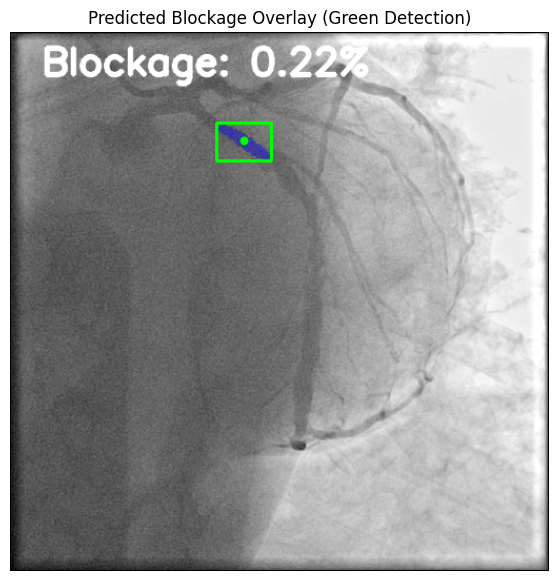

🩺 Computed blockage percentage (Green overlay): 0.22%


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Path to your overlay image
overlay_path = '/content/drive/MyDrive/ARCADE_outputs/overlays/overlay_uploaded_23.png'

# Load image
img = cv2.imread(overlay_path)
if img is None:
    print("❌ Could not read overlay image.")
else:
    # Convert to RGB + HSV
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Define HSV range for green color (tuneable if needed)
    lower_green = np.array([35, 40, 40])
    upper_green = np.array([90, 255, 255])

    # Create mask for green
    green_mask = cv2.inRange(hsv, lower_green, upper_green)

    # Compute blockage % based on green area
    blockage_percent = (np.sum(green_mask > 0) / green_mask.size) * 100

    # Draw the % on image
    display_img = img_rgb.copy()
    text = f"Blockage: {blockage_percent:.2f}%"
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(display_img, text, (30, 40), font, 1.2, (255, 255, 255), 3, cv2.LINE_AA)

    # Show overlay
    plt.figure(figsize=(7,7))
    plt.imshow(display_img)
    plt.title("Predicted Blockage Overlay (Green Detection)")
    plt.axis('off')
    plt.show()

    print(f"🩺 Computed blockage percentage (Green overlay): {blockage_percent:.2f}%")
